# Denoising Signal using Autoencoder

### *By Donovan Lo, Booz Allen Hamilton*
### *<lo_donovan@bah.com>*

This tutorial is introductory to denoising signal with Autoencoders. We will mainly be focused on the application of autoencoder and will not go in the math specifics. We hope by the end of the tutorial you have a good idea what an autoencoder is, and how it can be used towards denoising signal.  

### Table of Contents:
* [What are Autoencoders ?](#definition)
* [Setup](#setup)
* [Vanilla Autoencoder](#v_ae)
* [Multilayer Autoencoder](#m_ae)
    * [Build/Train Multilayer Autoencoder](#build_mae)
    * [Acoustic Data](#acoustic_data)
* [Convolutional Autoencoder](#conv_ae)
* [Summary](#summary)
* [Next Steps](#next_steps)
* [Reference](#ref)

## What are Autoencoders ? <a class="anchor" id="definition"></a>

Autoencoder is an [Artificial Neural Network (ANN)](https://en.wikipedia.org/wiki/Artificial_neural_network) trained to learn an encoded representation of an input data. This unsupervised mechanism does not require labels, and instead maps the recognized patterns to a set of compressed features, at which can then be converted to the same or a different presentation. 

Autoencoder is made up two neural networks. The first half is called the encoder and the second half is called the decoder. Both neural networks are made up of single or multiple hidden layers with [activation functions](https://en.wikipedia.org/wiki/Activation_function). The encoder and decoder are normally symmetrical in the number of hidden layers to ensure that the output's dimension retains the input's shape.  

<img src='./images/autoencoder.jpg' style='width: 40%' title='Autoencoder'> 

The encoder is responsible for taking the input data , learns the important features from the dataset and outputs a vector representation of the input. This vector representation in the latent space is called the encoded vector or code. The encoder utilizes dense, convolutional, and/or maxpool layers to help reduce the dimensionality of the input data.  

<img src='./images/VGG16.JPG' style='width: 40%' title='VGG16'> 
```
                                                Fig. VGG-16 architecture from Rovder
```

The decoder as the second component takes the encoded vector and uncompresses the information back to the input's dimension. The output of the deocoder can either be the same input pattern or some dedicated parttern that you have trained the neural network to learn. Unlike the encoder, this neural network uses convolutional transpose layers to expand the lower dimensional data to higher dimension, allowing the model to restore to the input's shape.

$$
loss = {|| x - y ||}^{2} = {|| x - d(z) ||}^{2} = {|| x - d(e(x)) ||}^{2}
$$

Where

    x is your input
    y or d(z), is your output or decoded code representation
    z or e(x) , encoded input


During the inference or feedforward flow, the input data goes through the encoder, then to the decoder, and outputs the desire pattern its trained on. The autoencoder is updated by performing a feedforward, the output is compared and evaluted against the desired output pattern for the error. The error is used in the backpropogation to update the weights/parameters in the hidden layer of the decoder and encoder. Like in a vanilla neural network, the update utilizes the gradient to make the appropriate change in the hidden layer's weights/parameters. 

This type of ANN is normaly seen in dimensionality reduction applications, such as data compression or [principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis). Other usage of Autoencoder includes Anomaly detection and Machine Translation. In this tutorial, we will focus on Autoencoders can be used to remove noise from signals. Before we start diving in on how Autoencoder can be constructed for denoising, lets touch on signals. 

<img src='./images/radio_waves.jpg' style='width: 60%' title='radio wave'> 
```
                                                Fig. Radio Waves from Kerbs
```

Signal is any data in time, used to be shared through a messaging system. The data can be acoustic, electromagnetic radio frequency, image/video, and so on. We will be examining acoustic signal in particular, but in order to ensure that the autoencoder neural network we build accepts the data type, we need to structure it a way that the model can understand it.  In this tutorial, we will convert the acoustic signal to an image representation, called Mel [spectrogram](https://en.wikipedia.org/wiki/Spectrogram). . In this image representation or 2D array of interger values, the Autoencoder can accept and perform math operation on it. 

<img src='./images/mel_spectrogram.jpg' style='width: 40%' title='mel spectrogram'> 

At the completion of this lab, the reader will have learned to use the [librosa](https://librosa.org/doc/latest/index.html) and [Keras](https://keras.io/) API to accomplish the following tasks:
- Restructure the Acoustic signal for Deep Learning modeling
- Design and implement Vanilla, Multilayer, and Convolutional Autoencoder
- Train and Evaluate the Autoencoders

## Setup <a class="anchor" id="setup"></a>

This tutorial is written in Python 3 and requires the following Python libraries. Although not required, the script will benefit from running on a GPU device. 

### Import Python Libraries

We will primarily use for `librosa` and `soundfile` for acoustic processing, and`tensorflow` with `keras` for training our Autoencoder. 

In [1]:
import os
import matplotlib
#matplotlib.use('Agg') # No pictures displayed 
import pylab
import librosa
import librosa.display
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from tqdm.keras import TqdmCallback
import tensorflow as tf
from keras.backend import clear_session

Using TensorFlow backend.


### MNIST Dataset 

Let's warm up with our "hello world" dataset to get familiar with handling image data types with our Autoencoder. [MNIST](http://yann.lecun.com/exdb/mnist/) is a handwritten digit made of 60,000 training examples, and 10,000 testing examples. This dataset is used for a long time now, to study image classification and image processing. The following code brings in the MNIST dataset in and visualizes it.

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


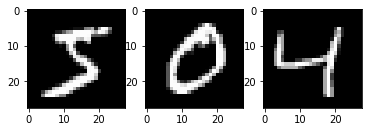

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X.astype('float32') / 255.
test_X = test_X.astype('float32') / 255.
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))
for i in range(3):  
    plt.subplot(1,3,i+1)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))

Since this tutorial is about denoising signals , let's add some noise to our dataset. There are variety of noising injections including [salt&pepper](https://en.wikipedia.org/wiki/Salt-and-pepper_noise), [gaussian](https://en.wikipedia.org/wiki/Gaussian_noise), [poisson](https://en.wikipedia.org/wiki/Shot_noise), and constructive/destructive signals. The code below will add salt&pepper noise to our MNIST dataset. 

In [3]:
noise_factor = 0.2
train_X_noisy = train_X + noise_factor * tf.random.normal(shape=train_X.shape) 
test_X_noisy = test_X + noise_factor * tf.random.normal(shape=test_X.shape) 

train_X_noisy = tf.clip_by_value(train_X_noisy, clip_value_min=0., clip_value_max=1.).numpy()
test_X_noisy = tf.clip_by_value(test_X_noisy, clip_value_min=0., clip_value_max=1.).numpy()

Below are some examples of noisy MNIST data. 

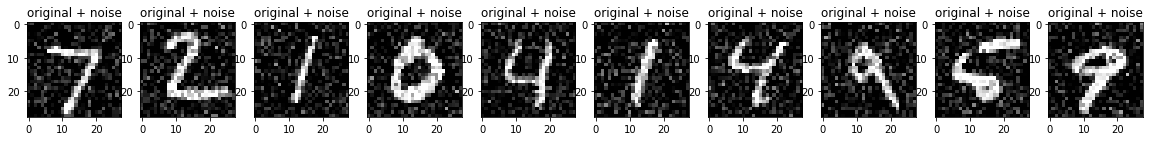

In [4]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(test_X_noisy[i]))
    plt.gray()
plt.show()

## Vanilla Autoencoder <a class="anchor" id="v_ae"></a>

Next, let's build a vanilla autoencoder that only has the barebone components. As mention before, there are two neural networks we can build and chain together. The encoder below accepts the image by taking the input's dimension, flattens the 2D input to a vector, and encodes it to a vector of size "code_size". 

We create another neural network for the decoder. It takes the vector of size "code_size" as the input, upsamples the number parameters to the input image size, and reshapes it's dimension to a 2D array. 

In [5]:
def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size, activation='relu'))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape)))
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [6]:
IMG_SHAPE = train_X[0].shape

encoder, decoder = build_autoencoder(IMG_SHAPE, 1000)
inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')
print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1000)              785000    
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28)            784784    
Total params: 1,569,784
Trainable params: 1,569,784
Non-trainable params: 0
_________________________________________________________________
None


From above, you can see that there are two layers with (None, 28, 28) . The 28x28 are the dimension size of each image in MNIST. The second layer in between those two is the coding layer that takes the size of the "code_size" we have specify or the number of parameters we would like the neural network to use to represent our encoded vector for each input image. 

Let's train the model ! Feel free to modify the epochs to something higher. Epochs is the number of iteration to have the model train through the entire set of dataset. 

In [7]:
history = autoencoder.fit(x=train_X_noisy, y=train_X, epochs=30,
                validation_data=[test_X_noisy, test_X])

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 7s 121us/step - loss: 0.0130 - val_loss: 0.0081
Epoch 2/30
60000/60000 [==============================] - 6s 108us/step - loss: 0.0076 - val_loss: 0.0073
Epoch 3/30
60000/60000 [==============================] - 6s 102us/step - loss: 0.0072 - val_loss: 0.0070
Epoch 4/30
60000/60000 [==============================] - 6s 106us/step - loss: 0.0070 - val_loss: 0.0070
Epoch 5/30
60000/60000 [==============================] - 6s 106us/step - loss: 0.0069 - val_loss: 0.0070
Epoch 6/30
60000/60000 [==============================] - 6s 106us/step - loss: 0.0068 - val_loss: 0.0068
Epoch 7/30
60000/60000 [==============================] - 6s 102us/step - loss: 0.0067 - val_loss: 0.0068
Epoch 8/30
60000/60000 [==============================] - 6s 106us/step - loss: 0.0066 - val_loss: 0.0066
Epoch 9/30
60000/60000 [==============================] - 6s 106us/step - loss: 0.0065 - val_loss: 0.0

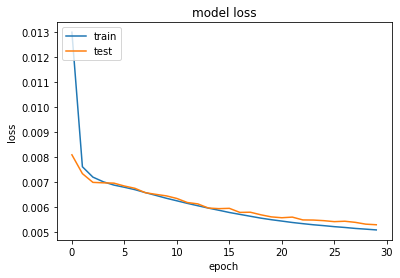

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

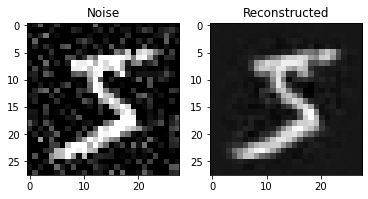

In [11]:
img = train_X_noisy[0]
code = encoder.predict(img[None])[0]
reco = decoder.predict(code[None])[0]

plt.subplot(1,2,1)
plt.title("Noise")
plt.imshow(img)

plt.subplot(1,2,2)
plt.title("Reconstructed")
plt.imshow(reco)

## Multilayer Autoencoder <a class="anchor" id="m_ae"></a>

In this section, we will move away from the vanilla Autoencoder and MNIST dataset and attempt to build a Multilayer Autoencoder with Acoustic signals. You might ask what makes a Multilayer and how do we go from MNIST dataset to a acoustic signal. We will look at acoustic signal data first , then discuss about the multilayer autoencoder. 

Let's bring in a wav file with the `librosa` library, convert it to a mel spectrogram, and visualize it. Below is recorded wav file of a person saying "hello". Spectrogram visualizes the intensity of spectrum frequencies respective to time. Time in the x-axis, and the Frequency in the y-axis. Mel is a scale , coming from the word melody, and representing the difference in pitches. 

In [12]:
sig, fs = librosa.load('./audio/hello.wav')   
save_path = 'hello.jpg'

pylab.axis('off') 
pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
M = librosa.feature.melspectrogram(y=sig, sr=fs)
librosa.display.specshow(librosa.power_to_db(M, ref=np.max))
pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
pylab.close()

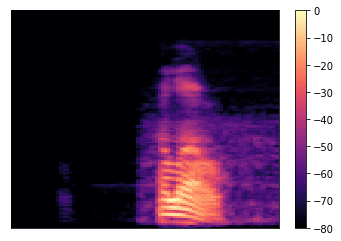

In [13]:
plt.figure()
librosa.display.specshow(librosa.power_to_db(M, ref=np.max))
plt.colorbar()

Convert the Mel Spectrogram back to a magnitude spectrogram, and save it to a wav file. 

In [17]:
S = librosa.feature.inverse.mel_to_stft(M)
y = librosa.griffinlim(S)

In [104]:
# write output
sf.write('./audio/reconstructed_hello.wav', y, fs)

Let's add salt & pepper noise to our mel spectrograms below. 

In [14]:
from skimage.util import random_noise

In [15]:
noise_img = random_noise(M, mode='s&p',amount=0.2)
noise_img = np.array(255*noise_img, dtype = 'float32')

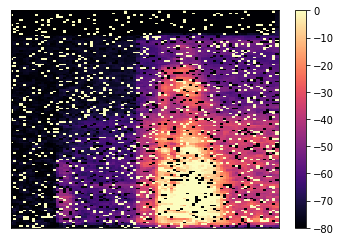

In [16]:
plt.figure()
librosa.display.specshow(librosa.power_to_db(noise_img, ref=np.max))
plt.colorbar()

We can convert the noisy mel spectrogram back to magnitude spectrogram , then save it out to a wav file to hear. Warning: The below code will take some time to run. 

In [105]:
# noise_S = librosa.feature.inverse.mel_to_stft(noise_img)
# noise_y = librosa.griffinlim(S)
# sf.write('noise_hello.wav', noise_y, fs)

Let's store the noisy mel spectrogram and the original mel spectrogram for training. 

In [17]:
train_x = noise_img[np.newaxis,:,:]
train_y = M[np.newaxis,:,:]

### Build/Train Multilayer Autoencoder <a class="anchor" id="build_mae"></a>

Now that we have the data ready. Let's build the Multilayer Autoencoder. Multilayer autoencoder structure wise has more than one hidden layers. By having multiple hidden layers, the neural network model is able to learn non-linear and more complex features compared to its one layer flavor. 

In [18]:
def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size, activation='relu'))
    encoder.add(Dense(code_size, activation='relu'))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    encoder.add(Dense(code_size, activation='relu'))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [19]:
IMG_SHAPE = train_x[0].shape

encoder, decoder = build_autoencoder(IMG_SHAPE, 1000)
inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

Try training the autoencoder for 100 epochs, then try a higher epoch size to see if you get any improvement. 

In [20]:
history = autoencoder.fit(x=train_x, y=train_y, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 147ms/step - loss: 466.5654
Epoch 2/100
1/1 [==============================] - 0s 10ms/step - loss: 1034.6996
Epoch 3/100
1/1 [==============================] - 0s 12ms/step - loss: 136.0894
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 49.5141
Epoch 5/100
1/1 [==============================] - 0s 13ms/step - loss: 20.2967
Epoch 6/100
1/1 [==============================] - 0s 12ms/step - loss: 12.8350
Epoch 7/100
1/1 [==============================] - 0s 12ms/step - loss: 11.5003
Epoch 8/100
1/1 [==============================] - 0s 10ms/step - loss: 11.4260
Epoch 9/100
1/1 [==============================] - 0s 12ms/step - loss: 11.3199
Epoch 10/100
1/1 [==============================] - 0s 13ms/step - loss: 11.2281
Epoch 11/100
1/1 [==============================] - 0s 12ms/step - loss: 11.1986
Epoch 12/100
1/1 [==============================] - 0s 12ms/step - loss: 11.1691
Epoch 13/100
1/1 [==============

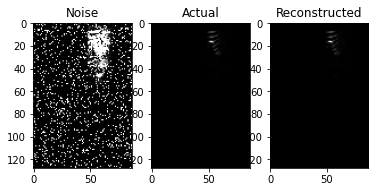

In [21]:
img = noise_img
code = encoder.predict(img[None])[0]
reco = decoder.predict(code[None])[0]

plt.subplot(1,3,1)
plt.title("Noise")
plt.imshow(img)

plt.subplot(1,3,2)
plt.title("Actual")
plt.imshow(M)

plt.subplot(1,3,3)
plt.title("Reconstructed")
plt.imshow(reco)

Visualizing our Noisy, Actual, and Reconstructed of our "hello" wav file, we can see that after 100 epochs of training we were able to remove the intensity of the salt & pepper noise and reduce the artifact created around our signal. 

Below we can convert the reconstructed signal to a magnitude spectrogram, and save it out to a wav file for a audio test. Warning: the conversion from mel to a magnitude spectrogram will take a long time to run. 

In [110]:
# recon_S = librosa.feature.inverse.mel_to_stft(reco*255)
# recon_y = librosa.griffinlim(recon_S)

# # write output
# sf.write('reconstructed_noise_hello.wav', recon_y, fs)

You can listen to all the wav files for the Actual, Noisy, and Reconstructed signal from the Autoencoder after 100 epochs of training. 

<table>
<tr>
<td> <audio controls src='./audio/hello.wav' title='Hello Audio' /> </td>
<td> <img src='./images/hello_normal.jpg' style='width: 50%' title='Normal Audio Spectrogram' /> </td>
</tr>
<tr>
<td> <audio controls src='./audio/noise_hello.wav' title='Noisy Hello Audio' /> </td>
<td> <img src='./images/hello_noise.jpg' style='width: 50%' title='Noisy Audio Spectrogram' /> </td>
</tr>
<tr>
<td> <audio controls src='./audio/reconstructed_noise_hello.wav' title='Recon Audio' /> </td>
<td> <img src='./images/hello_recon.jpg' style='width: 50%' title='Recon Audio Spectrogram' /> </td>
</tr>
</table>

### Acoustic Dataset <a class="anchor" id="acoustic_data"></a>

The "hello" wav file was just one acoustic example that we explored in the last section. In this section we will bring in more acoustic samples. Since, we do not have a public dataset of multiple people saying "hello" , we can look towards our furry friends' "hello" audio. 

The [Audio Cats and Dogs](https://www.kaggle.com/mmoreaux/audio-cats-and-dogs) Kaggle datset was a nod to the "cats and dogs" image classification dataset. This dataset has both cats and dogs audio for people to create models to classify raw sound events. We will take these audio files, add noise to it, so we can create an Autoencoder. 

For tutorial purposes, we will only pick one of our furry friends audio. I have chosen to extract out all training and testing dataset for dogs. Feel free to play with other audio set if you want to experiment. 

In [22]:
import os

dog_train_directory = "./cats_dogs/train/dog"
dog_train_files = []
for path, subdirs, files in os.walk(dog_train_directory):
    for name in files:
        if name.endswith('wav'):
            dog_train_files.append( os.path.join(path, name) )
            
dog_test_directory = "./cats_dogs/test/dog"
dog_test_files = []
for path, subdirs, files in os.walk(dog_test_directory):
    for name in files:
        if name.endswith('wav'):
            dog_test_files.append( os.path.join(path, name) )

Create a data generator, so we don't have to load and store all the data in to memory. The data generator will only read in the necessary batch size of data for the model we design in to memory during training. In the generator, we implemented a piece of the code to inject the salt and pepper noise on to our mel spectrogram. 

In [25]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, dim, filenames, shuffle, batch_size):
        self.dim = dim
        self.filenames = filenames
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.list_IDs  = range(len(filenames))
        self.on_epoch_end()
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.list_IDs[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs [k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim[0], self.dim[0], 1))
        y = np.empty((self.batch_size, self.dim[0], self.dim[0], 1))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            sig, fs = librosa.load(self.filenames[ID], duration=4)  
            M = librosa.feature.melspectrogram(y=sig, sr=fs)
            M = M[:self.dim[0],:self.dim[1]]
            pad_row=max(0,self.dim[0]-M.shape[0])
            #pad_col=max(0,self.dim[1]-M.shape[1])
            pad_col=max(0,self.dim[0]-M.shape[1])
            M = np.pad(M,((0,pad_row),(0,pad_col)),'constant')
            noise_img = random_noise(M, mode='s&p',amount=0.2)
            noise_img = np.array(M.max()*noise_img, dtype = 'float32')
            # Store noisy spectrogram
            X[i,] = noise_img[..., np.newaxis]
            # Store original spectrogram
            y[i] = M[..., np.newaxis]

        return X, y

Create the training and testing generator for our dog friend

In [26]:
train_params = {'dim': (128,128),
         'filenames': dog_train_files,
         'batch_size': 16,
         'shuffle': True}
test_params = {'dim': (128,128),
         'filenames': dog_test_files,
         'batch_size': 16,
         'shuffle': True}
training_generator = DataGenerator(**train_params)
testing_generator = DataGenerator(**test_params)

Rebuild the same Multilayer Autoencoder that we used for our "hello" sample. 

In [27]:
def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size, activation='relu'))
    encoder.add(Dense(code_size, activation='relu'))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(code_size)) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Dense(np.prod(img_shape)))
    decoder.add(Reshape(img_shape))

    return encoder, decoder

IMG_SHAPE = (img.shape[0], img.shape[0],1)

encoder, decoder = build_autoencoder(IMG_SHAPE, 1000)
inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse', metrics=['accuracy'])

Train on the dog noisy audio dataset that we have craeted. 

In [28]:
history = autoencoder.fit(training_generator,validation_data=testing_generator, epochs=100)

Epoch 1/100
85/85 [==============================] - 7s 82ms/step - loss: 74250.5143 - accuracy: 0.9375 - val_loss: 5.1723e-06 - val_accuracy: 0.9375
Epoch 2/100
85/85 [==============================] - 7s 81ms/step - loss: 3194.0413 - accuracy: 0.9375 - val_loss: 5.9919e-06 - val_accuracy: 0.9376
Epoch 3/100
85/85 [==============================] - 7s 84ms/step - loss: 493.5549 - accuracy: 0.9376 - val_loss: 6.5342e-06 - val_accuracy: 0.9376
Epoch 4/100
85/85 [==============================] - 7s 78ms/step - loss: 352.0884 - accuracy: 0.9376 - val_loss: 6.6330e-06 - val_accuracy: 0.9376
Epoch 5/100
85/85 [==============================] - 7s 79ms/step - loss: 327.0528 - accuracy: 0.9376 - val_loss: 7.0690e-06 - val_accuracy: 0.9376
Epoch 6/100
85/85 [==============================] - 7s 80ms/step - loss: 301.7560 - accuracy: 0.9377 - val_loss: 7.5455e-06 - val_accuracy: 0.9376
Epoch 7/100
85/85 [==============================] - 7s 80ms/step - loss: 284.7788 - accuracy: 0.9377 - val_l

85/85 [==============================] - 7s 81ms/step - loss: 236.4977 - accuracy: 0.9414 - val_loss: 6.2797e-04 - val_accuracy: 0.9415
Epoch 57/100
85/85 [==============================] - 7s 82ms/step - loss: 235.7050 - accuracy: 0.9424 - val_loss: 6.5405e-04 - val_accuracy: 0.9415
Epoch 58/100
85/85 [==============================] - 7s 81ms/step - loss: 235.6418 - accuracy: 0.9424 - val_loss: 6.9131e-04 - val_accuracy: 0.9415
Epoch 59/100
85/85 [==============================] - 7s 81ms/step - loss: 233.7591 - accuracy: 0.9424 - val_loss: 7.3990e-04 - val_accuracy: 0.9415
Epoch 60/100
85/85 [==============================] - 7s 82ms/step - loss: 257.0529 - accuracy: 0.9420 - val_loss: 8.2273e-04 - val_accuracy: 0.9415
Epoch 61/100
85/85 [==============================] - 7s 85ms/step - loss: 237.6392 - accuracy: 0.9421 - val_loss: 8.6088e-04 - val_accuracy: 0.9415
Epoch 62/100
85/85 [==============================] - 7s 78ms/step - loss: 235.7554 - accuracy: 0.9420 - val_loss: 9.10

In [29]:
score = autoencoder.evaluate(testing_generator,verbose=0)
print("Autoencoder MSE:", score)

Autoencoder MSE: [0.0023995316587388515, 0.9414080381393433]


In [38]:
test_sample = testing_generator.__getitem__(0)
batch_test_x = test_sample[0]
batch_test_y = test_sample[1]

i = 0
img = batch_test_x[i]
M = batch_test_y[i]

In [39]:
batch_test_x.shape

(16, 128, 128, 1)

(16, 128, 128, 1)

(128, 128, 1)

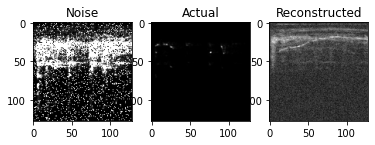

In [41]:
# Get a random signal from our test batch
display(batch_test_x.shape)
sample_1 = batch_test_x[0]
display(sample_1.shape)

img = sample_1
code = encoder.predict(img[None])[0]
reco = decoder.predict(code[None])[0]

# Display 
plt.subplot(1,3,1)
plt.title("Noise")
plt.imshow(img)

plt.subplot(1,3,2)
plt.title("Actual")
plt.imshow(M)

plt.subplot(1,3,3)
plt.title("Reconstructed")
plt.imshow(reco)

# Convolutional Autoencoder <a class="anchor" id="conv_ae"></a>

Up until now, we have implemented vanilla and multilayer autoencoder. When working with image processing, in our case mel spectrogram, we can look to leverage convolutional autoencoder. Convolutional autoencoder utilizes the 2D array as context to learn features compared to the former one dimensional information. The autoencoder architecturaly still includes the encoder and the decoder. The concept is still the same for vanilla, multilayer, and convolutional autoencoder. 

<img src='./images/conv_autoencoder.jpg' style='width: 40%' title='Conv Autoencoder'> 

In the encoder, when we reduce the dimensionality of the input data, we use the [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), and [MaxPool](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) Layers. The Conv2D is often seen in computer vision tasks, when we want to train a model to learn features of the objects that the user wants to detect. The features/filters is slowly updated to look like subcomponents of the object detected. When the learned filters performs a product on the input images, it activates areas on the input image space that indicates the object features it has learned. 

On the other end, the decoder upsamples by using the [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) Layer. Since upsampling is not a common mechanism in neural network we experiment and visualize to get a feel on what the operation does. Below are some code to perform a Conv2D transpose operation. 

In [42]:
def conv2d_transpose(img_size, filter_size):
    print(f"conv2d_tranpose: img_size={img_size}, filter_size={filter_size}")
    
    # Create a img_size by img_size input image 
    x = np.arange(img_size*img_size, dtype=np.float32)+1
    x = x.reshape((1, img_size, img_size, 1))
    # Create filters of all ones
    f = (np.ones(filter_size*filter_size, dtype=np.float32))
    f = f.reshape((filter_size, filter_size, 1, 1))

    output = tf.nn.conv2d_transpose(x, f, 
                                  output_shape=(1, img_size * 2, img_size * 2, 1), 
                                  strides=[1, 2, 2, 1], 
                                  padding='SAME')
    # Display the Input, Filter, Output
    print("Input:")
    print(x[0, :, :, 0])
    print("Filter:")
    print(f[:, :, 0, 0])
    print("Output:")
    print(output[0, :, :, 0])
    print("\n")

Below you can modify the image size and the filter size to see what the results look like with the Conv2D tranpose operation. 

In [43]:
conv2d_transpose(img_size=2, filter_size=2)
conv2d_transpose(img_size=2, filter_size=3)
conv2d_transpose(img_size=2, filter_size=4)

conv2d_tranpose: img_size=2, filter_size=2
Input:
[[1. 2.]
 [3. 4.]]
Filter:
[[1. 1.]
 [1. 1.]]
Output:
tf.Tensor(
[[1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [3. 3. 4. 4.]
 [3. 3. 4. 4.]], shape=(4, 4), dtype=float32)


conv2d_tranpose: img_size=2, filter_size=3
Input:
[[1. 2.]
 [3. 4.]]
Filter:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
Output:
tf.Tensor(
[[ 1.  1.  3.  2.]
 [ 1.  1.  3.  2.]
 [ 4.  4. 10.  6.]
 [ 3.  3.  7.  4.]], shape=(4, 4), dtype=float32)


conv2d_tranpose: img_size=2, filter_size=4
Input:
[[1. 2.]
 [3. 4.]]
Filter:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Output:
tf.Tensor(
[[ 1.  3.  3.  2.]
 [ 4. 10. 10.  6.]
 [ 4. 10. 10.  6.]
 [ 3.  7.  7.  4.]], shape=(4, 4), dtype=float32)




Below we will write the layers for the Convolutional Autoencoder. 

In [44]:
def build_deep_autoencoder(img_shape, code_size):
    """PCA's deeper brother. See instructions above. Use `code_size` in layer definitions."""
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(InputLayer(img_shape))

    encoder.add(Conv2D(filters=8,kernel_size=(3,3),padding='same',activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2,2)))
    encoder.add(Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2,2)))
    encoder.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2,2)))
    encoder.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2,2)))
    encoder.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2,2)))
    encoder.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
    encoder.add(MaxPooling2D(pool_size=(2,2)))
    encoder.add(Flatten())                  #flatten image to vector
    encoder.add(Dense(code_size))           #actual encoder

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(InputLayer((code_size,)))
   
    decoder.add(Dense(2*2*256))
    decoder.add(Reshape((2,2,256)))
    decoder.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(Conv2DTranspose(filters=8, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(Conv2DTranspose(filters=1, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder

Let's instantiate the convolutional autoencoder and examine the encoder and the decoder layers.

In [45]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=1000)
encoder.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 8)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)       

In [46]:
decoder.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1024)              1025024   
_________________________________________________________________
reshape_4 (Reshape)          (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 128)         295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 32)        18464     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 32, 32, 16)        4624      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 64, 64, 8)        

In [47]:
inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse',metrics=['accuracy'])

Let's train the awesome model !

In [48]:
model_filename = 'autoencoder.hdf5'
last_finished_epoch = None
checkpoint=tf.keras.callbacks.ModelCheckpoint(model_filename, monitor='val_loss', verbose=0, save_best_only=False)

## loading the previously fit model.
autoencoder.fit(training_generator, epochs=20,
                validation_data=testing_generator,
                callbacks=[checkpoint])

Epoch 1/20
85/85 [==============================] - 7s 83ms/step - loss: 457.0532 - accuracy: 0.9397 - val_loss: 2.8502e-05 - val_accuracy: 0.9395
Epoch 2/20
85/85 [==============================] - 7s 77ms/step - loss: 235.2280 - accuracy: 0.9402 - val_loss: 4.7160e-05 - val_accuracy: 0.9392
Epoch 3/20
85/85 [==============================] - 7s 79ms/step - loss: 234.7331 - accuracy: 0.9397 - val_loss: 7.1464e-05 - val_accuracy: 0.9390
Epoch 4/20
85/85 [==============================] - 7s 78ms/step - loss: 234.2116 - accuracy: 0.9394 - val_loss: 9.7823e-05 - val_accuracy: 0.9389
Epoch 5/20
85/85 [==============================] - 6s 76ms/step - loss: 233.5999 - accuracy: 0.9394 - val_loss: 1.2658e-04 - val_accuracy: 0.9391
Epoch 6/20
85/85 [==============================] - 7s 78ms/step - loss: 233.0704 - accuracy: 0.9398 - val_loss: 1.5521e-04 - val_accuracy: 0.9389
Epoch 7/20
85/85 [==============================] - 7s 79ms/step - loss: 232.6153 - accuracy: 0.9393 - val_loss: 1.978

Once trained, we can visualize how well the Convolutional Autoencoder does. 

In [49]:
test_sample = testing_generator.__getitem__(0)
batch_test_x = test_sample[0]
batch_test_y = test_sample[1]

i = 0
img = batch_test_x[i]
M = batch_test_y[i]

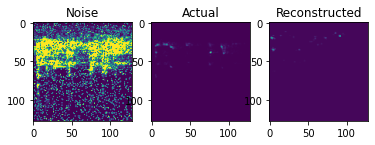

In [680]:
code = encoder.predict(img[None])[0]
reco = decoder.predict(code[None])[0]

plt.subplot(1,3,1)
plt.title("Noise")
plt.imshow(img)

plt.subplot(1,3,2)
plt.title("Actual")
plt.imshow(M)

plt.subplot(1,3,3)
plt.title("Reconstructed")
plt.imshow(reco)

In [681]:
reconstruction_mse = autoencoder.evaluate(testing_generator, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)

Convolutional autoencoder MSE: [0.010865902528166771, 0.9414052963256836]


## Summary <a class="anchor" id="summary"></a>

To recap on the tutorial, we have tackled and discussed: 
- Definition and architecture of Autoencoder
- Different Signal data types
- How to transform acoustic signal to mel spectrogram, and inject noise
- Implement Vanilla, Multilayer, and Convolutional Autoencoder
- Train and Evaluate the Autoencoders

## Next Steps <a class="anchor" id="next_steps"></a>

Below are some additional concepts you can explore:
- Try a different noise injections (gaussian, poisson, artificial markings)
- Try modifying the autoencoder hyperparameters
    - number of hidden layers
    - [activation functions](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
    - size of the code size, smaller or larger code representation
    - size of the input/output (mel spectrogram) 
- Switch to other types of Autoencoders such as the Variational autoencoder (VAE)
    - VAE's training is regularized to avoid overfitting and unlike the autoencoder that encodes the input to single points, VAE encodes it as a distribution in the latent space. 

## References <a class="anchor" id="ref"></a>

### Paper
- [Hinton, G. E.; Salakhutdinov, R.R. (2006-07-28). "Reducing the Dimensionality of Data with Neural Networks"](https://www.cs.toronto.edu/~hinton/science.pdf)
- [ Cho, K. (2013, February). Simple sparsification improves sparse denoising autoencoders in denoising highly corrupted images](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.360.8534&rep=rep1&type=pdf)
- [On the Properties of Neural Machine Translation: Encoder-Decoder Approaches](https://arxiv.org/abs/1409.1259)
- [S.Rovder; J.Cano, M.OBoyle. "Optimising Convolutional Neural Networks Inference on Low-Powered GPUs"](https://www.researchgate.net/publication/330638173_Optimising_Convolutional_Neural_Networks_Inference_on_Low-Powered_GPUs)

### Blogs

- [L.Kerbs; G.Williams. "Deep Learning for Radio Waves"](https://medium.com/gsi-technology/deep-learning-for-radio-waves-c240446711d1)

                         

### Contact : *lo_donovan@bah.com*

<img src='./images/bah.jpg' style='width: 40%' title='BAH'> 
